In [2]:
# This Notebook is for measuring the popularity of test items
from collections import Counter
from experiments.data_loader import DataLoader
from shared.enums import Sentiment
import numpy as np
from scipy import stats 
from matplotlib import pyplot as plt 
import seaborn as sns


data_loader = DataLoader('../../data/movielens/split_0')

entity_ratings = dict()

for user, ratings in data_loader.training().items():
    for item, rating in ratings.training.items():
        entity_ratings[item] = entity_ratings.get(item, 0) + 1
        pass

print(entity_ratings)

FileNotFoundError: [Errno 2] No such file or directory: '../../data/movielens/split_0/training.pkl'

np.mean(differences)=13.922166575367807
DescribeResult(nobs=153, minmax=(2, 212), mean=56.908496732026144, variance=2438.7942036463705, skewness=1.1197721773745033, kurtosis=0.5534471086148738)
np.median(positive_ratings)=42.0
DescribeResult(nobs=15300, minmax=(1, 212), mean=41.21137254901961, variance=1018.8453115351638, skewness=1.1099991030778964, kurtosis=1.2554382775897714)
np.median(unseen_ratings)=33.0
34.400000000000006
3.0


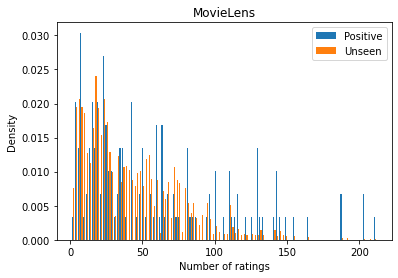

In [110]:
# How popular are positive items compared to unseen samples

positive_ratings = list()
unseen_ratings = list()
differences = list()

for user, ratings in data_loader.testing().items():
    items = set()
    for cold_set in ratings.sets:
        positive_items = cold_set.ranking.sentiment_samples[Sentiment.POSITIVE]
        unseen_items = cold_set.ranking.sentiment_samples[Sentiment.UNSEEN]
        
        for item in positive_items:
            positive_ratings.append(entity_ratings.get(item, 0))
            
        for item in unseen_items:
            unseen_ratings.append(entity_ratings.get(item, 0))
            
        differences.append(np.mean(positive_ratings) - np.mean(unseen_ratings))

print(f'{np.mean(differences)=}')
print(stats.describe(positive_ratings))
print(f'{np.median(positive_ratings)=}')
print(stats.describe(unseen_ratings))
print(f'{np.median(unseen_ratings)=}')

print(f'{np.percentile(positive_ratings, 45)}')
print(f'{np.percentile(unseen_ratings, 3)}')
plt.hist([positive_ratings, unseen_ratings], bins=109, label=['Positive', 'Unseen'], density=True)
plt.legend(loc='upper right')
plt.xlabel('Number of ratings')
plt.ylabel('Density')
plt.title('MovieLens')
plt.savefig('sampling_popularity_bias.pdf', bbox_inches='tight')

In [111]:
# How many unique positive samples we have per test user
test_ratings = dict()
unseen_ratings = dict()
lengths = []

for user, ratings in data_loader.testing().items():
    items = set()
    for cold_set in ratings.sets:
        positive_items = cold_set.ranking.sentiment_samples[Sentiment.POSITIVE]
        
        items.update(positive_items)

    lengths.append(len(items))

print(stats.describe(lengths))

DescribeResult(nobs=153, minmax=(1, 1), mean=1.0, variance=0.0, skewness=0.0, kurtosis=-3.0)


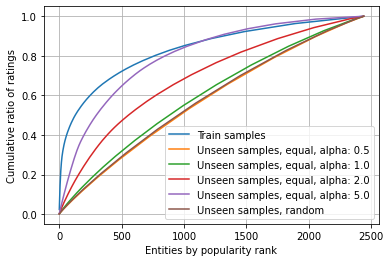

In [3]:
# Comparison of different sampling strategies
def dosomething(path):
    data_loader = DataLoader(path)
    training = data_loader.training()
    testing = data_loader.testing()
    
    train_ratings = []
    train_pos_rating = []
    for user, warm in training.items():
        for entity, rating in warm.training.items():
            train_ratings.append(entity)
            if rating == 1:
                train_pos_rating.append(entity)
    
    r_train = Counter(train_ratings)
    pr_train = Counter(train_pos_rating)
    
    test_answ_ratings = []
    test_pos_answ_ratings = []
    test_ratings = []
    test_pos_ratings = []
    
    for user, cold in testing.items():
        for set in cold.sets:
            for entity, rating in set.answers.items():
                test_answ_ratings.append(entity)
                if rating == 1:
                    test_pos_answ_ratings.append(entity)
            for entity in set.ranking.get_seen_samples():
                test_pos_ratings.append(entity)
            t = set.ranking.get_seen_samples()
            for entity in set.ranking.to_list(): 
                if entity not in set.ranking.get_seen_samples():
                    test_ratings.append(entity)
                
    r_test_ans = Counter(test_answ_ratings)
    pr_test_ans = Counter(test_pos_answ_ratings)
    r_test = Counter(test_ratings)
    pr_test = Counter(test_pos_ratings)
    
    return r_train, pr_train, r_test_ans, pr_test_ans, r_test, pr_test

def cumulative_ratio(ordered_values):
    tot = 0
    array = np.zeros((len(ordered_values),))
    for i, val in enumerate(ordered_values):
        tot += val
        array[i] = tot
        
    return array / tot

equal_path = '../../data/default_equal_popularityalpha0.5/split_0'
res = dosomething(equal_path)

r_train, _, _, _, r_test, _ = [
    sorted(r.items(), key=lambda x: x[1], reverse=True) for r in res
]

_,y1 = zip(*r_train)
_,y2 = zip(*r_test)

equal_path = '../../data/default_equal_popularityalpha1.0/split_0'
res = dosomething(equal_path)

_, _, _, _, r_test, _ = [
    sorted(r.items(), key=lambda x: x[1], reverse=True) for r in res
]

_,y6 = zip(*r_test)


equal_path = '../../data/default_equal_popularityalpha2.0/split_0'
res = dosomething(equal_path)

_, _, _, _, r_test, _ = [
    sorted(r.items(), key=lambda x: x[1], reverse=True) for r in res
]

_,y7 = zip(*r_test)

equal_path = '../../data/default_equal_popularityalpha5.0/split_0'
res = dosomething(equal_path)

_, _, _, _, r_test, _ = [
    sorted(r.items(), key=lambda x: x[1], reverse=True) for r in res
]

_,y8 = zip(*r_test)

equal_path = '../../data/default_rec/split_0'
res = dosomething(equal_path)

_, _, r_test_ans, _, r_test, pr_test = [
    sorted(r.items(), key=lambda x: x[1], reverse=True) for r in res
]

_,y3 = zip(*pr_test)
_,y4 = zip(*r_test)
_,y5 = zip(*r_test_ans)
r = min(len(y1), 
        len(y2), 
        # len(y3), 
        len(y4), 
        # len(y5),
        len(y6),
        len(y7),
        len(y8),
        )
plt.plot(range(r), cumulative_ratio(y1[:r]), label = "Train samples")
# plt.plot(range(r), cumulative_ratio(y5[:r]), label= 'Test answer samples')
plt.plot(range(r), cumulative_ratio(y2[:r]), label= 'Unseen samples, equal, alpha: 0.5')
plt.plot(range(r), cumulative_ratio(y6[:r]), label= 'Unseen samples, equal, alpha: 1.0')
plt.plot(range(r), cumulative_ratio(y7[:r]), label= 'Unseen samples, equal, alpha: 2.0')
plt.plot(range(r), cumulative_ratio(y8[:r]), label= 'Unseen samples, equal, alpha: 5.0')
# plt.plot(range(r), cumulative_ratio(y3[:r]), label = "Seen samples, uniform")
plt.plot(range(r), cumulative_ratio(y4[:r]), label= 'Unseen samples, random')
plt.legend()
# plt.yscale('log')
plt.xlabel('Entities by popularity rank')
plt.ylabel('Cumulative ratio of ratings')
plt.grid()
plt.savefig('./results/cumulative_sampling.pdf', bbox_inches='tight')
plt.show()